In [ ]:
# Drowsiness Driving Detection 운전자 졸음 방지

In [ ]:
##data_loader.py##

from torch.utils.data import Dataset
import torch


class eyes_dataset(Dataset):
    def __init__(self, x_file_paths, y_file_path, transform=None):
        self.x_files = x_file_paths
        self.y_files = y_file_path
        self.transform = transform

    def __getitem__(self, idx):
        x = self.x_files[idx]
        x = torch.from_numpy(x).float()

        y = self.y_files[idx]
        y = torch.from_numpy(y).float()  #GPU 연산을 위해 자료형을 tensor로 변환

        return x, y

    def __len__(self):
        return len(self.x_files)


#제가 찾은 예제에서 x_file과 y_file은 형식이 npy라는 확장자를 가진 이미지입니다.
#npy는 numpy 자료형으로 이미지를 저장합니다.

# x_file의 shape은 (2586,26,34,1) -> 2586개 데이터의 width=26, height=34, channel=1로 구성됩니다.
# y_file의 shape은 (2586, 1) -> 2586개의 데이터 각각에 라벨링이 있습니다.
  # 라벨링은 눈을 감으면 0, 뜨면 1로 구성됩니다.

In [ ]:
##model.py##

import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # 1. Conv2d(input_channel_size, output_volume_size, kernel_size)
        
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        # 흑백 1장, 채널 수는 32, 채널 크기는 3
        # 결과 : 32개의 필터(채널)은 32개의 특징맵 생성
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        # covn2에서 64개의 필터(채널)은 각각 conv1에서 나온 32개의 특징맵을 보고 다시 1개의 특징맵을 생성 → 총 64개의 특징맵 생성
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        # conv3도 마찬가지

        # 2. activation
        self.fc1 = nn.Linear(1536, 512)
        self.fc2 = nn.Linear(512, 1)

    def forward(self, x):
        # 3. pool
        x = F.max_pool2d(F.relu(self.conv1(x)),2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = F.max_pool2d(F.relu(self.conv3(x)), 2)
        x = x.reshape(-1, 1536)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)


        return x


# model은 binary classification / 눈을 감으면 0, 뜨면 1
# Conv, activation, pool의 3번의 과정을 거쳐 2번의 linear layer을 통해 최종적인 값이 나옴
# 이 최종적인 값으로 loss를 구하고, Probability를 구해 boundary를 0.5로 잡고 눈을 감았는지 떴는지 판단

# 컨브넷은 (image_height, image_width, image_channels) 크기의 입력 텐서 사용
    # 여기서는 input_shape=(26,34,1)임


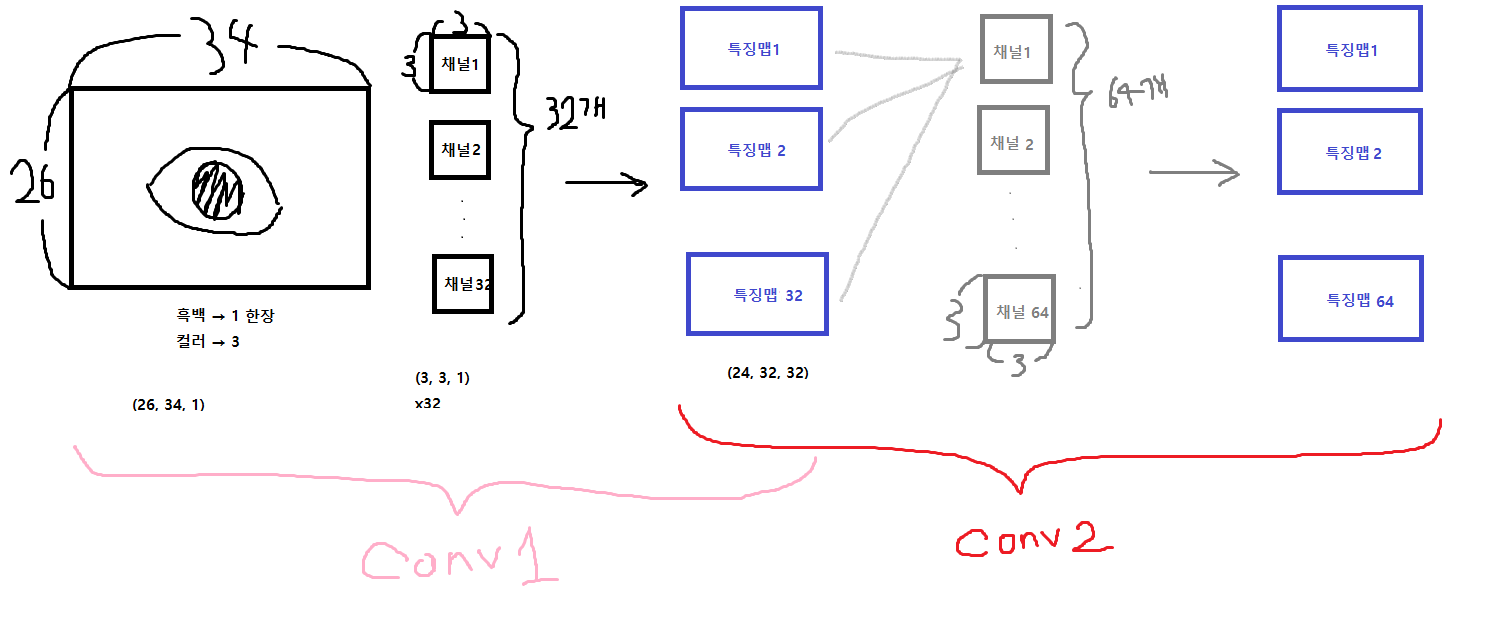

In [ ]:
model = Net().to('cuda')
summary(model, (1,26,34))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 34]             320
            Conv2d-2           [-1, 64, 13, 17]          18,496
            Conv2d-3            [-1, 128, 6, 8]          73,856
            Linear-4                  [-1, 512]         786,944
            Linear-5                    [-1, 1]             513
Total params: 880,129
Trainable params: 880,129
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.37
Params size (MB): 3.36
Estimated Total Size (MB): 3.74
----------------------------------------------------------------
